In [1]:
import os
import sqlite3

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import seaborn as sns

import numpy as np
import nfts.dataset

import pandas as pd
import math

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

from yellowbrick.cluster import SilhouetteVisualizer
from kneed import KneeLocator
import pyclustertend

In [2]:
nfts_merged_df = pd.read_csv("data/nfts_merged.csv")

In [3]:
dirname = os.path.dirname(os.path.abspath("__file__"))
DATASET_PATH = os.path.join(dirname, "data/nfts.sqlite")
ds = nfts.dataset.FromSQLite(DATASET_PATH)

nfts_df = ds.load_dataframe("nfts")
nfts_df.rename(columns={'address':"nft_address"}, inplace=True)
nfts_df.head()

,nft_address,name,symbol
0,0xF4ee95274741437636e748DdAc70818B4ED7d043,The Doge Pound,DOGGY
1,0xba30E5F9Bb24caa003E9f2f0497Ad287FDF95623,BoredApeKennelClub,BAKC
2,0x7403AC30DE7309a0bF019cdA8EeC034a5507cbB3,Characters,CHAR
3,0x511372B44231a31527025a3D273C1dc0a83D77aF,Maps Restored,MAP
4,0x2E956Ed3D7337F4Ed4316A6e8F2EdF74BF84bb54,Neon Junkies,JUNKIES


Collections with most contracts

In [4]:
collections_df = nfts_df.groupby('name', as_index=False).size().rename(columns={'size':'num_addresses'})
collections_df.sort_values('num_addresses', ascending=False, inplace=True)

collections_df.head()

,name,num_addresses
4894,NFT Basket,68
0,,19
4933,NFT-LOTTERY,16
7406,Tinlake Loan Token,13
568,Artiikorea,9


# Datasets Merging

## Tables loading and projection

In [5]:
mints_df = ds.load_dataframe("mints")
mints_df = mints_df[['nft_address', 'transaction_value', 'timestamp']]

In [ ]:
transfers_df = ds.load_dataframe("transfers")
transfers_df = transfers_df[['nft_address', 'transaction_value']]

transfers_stats_df = ds.load_dataframe("transfer_statistics_by_address")
transfers_stats_df.rename(columns={'address':"owner_address"}, inplace=True)

In [ ]:
current_owners_df = ds.load_dataframe("current_owners")
current_owners_df = current_owners_df[['nft_address', 'owner']]

In [ ]:
current_market_values_df = ds.load_dataframe("current_market_values")
current_market_values_df = current_market_values_df[['nft_address', 'market_value']]

In [ ]:

# TODO: remove cell

print(list(nfts_df.keys()), "nfts")

print(list(mints_df.keys()), "mints")
print(list(transfers_df.keys()), "transfers")
print(list(transfers_stats_df.keys()), "transfers stats")
print(list(current_owners_df.keys()), "owners")
print(list(current_market_values_df.keys()), "values")

['nft_address', 'name', 'symbol'] nfts
['nft_address', 'transaction_value', 'timestamp'] mints
['nft_address', 'transaction_value'] transfers
['owner_address', 'transfers_out', 'transfers_in'] transfers stats
['nft_address', 'owner'] owners
['nft_address', 'market_value'] values


There's a total of 9388 NFT unique addresses, as in the *nfts dataset*

None of the other addresses contains this number of addresses, therefore there are addresses withoutdata on minting, owners and value

In [ ]:

print("nft unique addresses:\t", nfts_df["nft_address"].nunique(), " / ", len(nfts_df))
print("Mints unique addresses:\t", mints_df["nft_address"].nunique(), " / ", len(mints_df))
print("Transfers unique addresses:\t", transfers_df["nft_address"].nunique(), " / ", len(transfers_df))
print("Owners unique addresses:\t", current_owners_df["nft_address"].nunique(), " / ", len(current_owners_df))
print("Values unique addresses:\t", current_market_values_df["nft_address"].nunique(), " / ", len(current_market_values_df))


nft unique addresses:	 9388  /  9388
Mint unique addresses:	 7647  /  6667282
Transfers unique addresses:	 6701  /  4514729
Owners unique addresses:	 9292  /  7020950
Values unique addresses:	 9292  /  7020950


## GroupBy and Aggregate

In [ ]:

# TODO: for each nft_address, number of transfers (see transfers.ipynb)

nfts_merged_df = nfts_df

# for mints, take the average transaction_value and the difference in timestamp
mints_agg_df = mints_df.groupby("nft_address", as_index=False).aggregate({'transaction_value': 'mean', 
                                                                            'timestamp': lambda x: x.max() - x.min()})
mints_agg_df.rename(columns={"transaction_value":"mints_avg_transaction_value", "timestamp":"mints_timestamp_range"}, inplace=True)
nfts_merged_df = nfts_merged_df.merge(mints_agg_df, on="nft_address", how="left")

# for transfers, take the average transaction_value
transfers_agg_df = transfers_df.groupby("nft_address", as_index=False).aggregate(transfers_avg_transaction_value=pd.NamedAgg(column="transaction_value", aggfunc="mean"),
                                                                                    transfers_count=pd.NamedAgg(column="transaction_value", aggfunc="count"))
nfts_merged_df = nfts_merged_df.merge(transfers_agg_df, on="nft_address", how="left")

# number of current owners
owners_agg_df = current_owners_df.groupby("nft_address", as_index=False).count()
owners_agg_df.rename(columns={"owner":"num_owners"}, inplace=True) 
nfts_merged_df = nfts_merged_df.merge(owners_agg_df, on="nft_address", how="left")

# average market values
values_agg_df = current_market_values_df.groupby("nft_address", as_index=False).mean()
values_agg_df.rename(columns={"market_value":"avg_market_value"}, inplace=True) 
nfts_merged_df = nfts_merged_df.merge(values_agg_df, on="nft_address", how="left")

Costs conversion to ETH

In [ ]:
nfts_merged_df["mints_avg_transaction_value"] = nfts_merged_df["mints_avg_transaction_value"] / (10**18)
nfts_merged_df["transfers_avg_transaction_value"] = nfts_merged_df["transfers_avg_transaction_value"] / (10**18)
nfts_merged_df["avg_market_value"] = nfts_merged_df["avg_market_value"] / (10**18)

nfts_merged_df.to_csv("data/nfts_merged.csv", index=False)
nfts_merged_df.head()

,nft_address,name,symbol,mints_avg_transaction_value,mints_timestamp_range,transfers_avg_transaction_value,transfers_count,num_owners,avg_market_value
0,0xF4ee95274741437636e748DdAc70818B4ED7d043,The Doge Pound,DOGGY,0.833024,444184.0,0.809497,15352.0,10000.0,1.013126
1,0xba30E5F9Bb24caa003E9f2f0497Ad287FDF95623,BoredApeKennelClub,BAKC,0.000000,605983.0,1.782388,18137.0,9602.0,1.701389
2,0x7403AC30DE7309a0bF019cdA8EeC034a5507cbB3,Characters,CHAR,0.019601,1508463.0,0.144810,4308.0,7242.0,0.077697
3,0x511372B44231a31527025a3D273C1dc0a83D77aF,Maps Restored,MAP,0.000000,1802082.0,0.107217,791.0,4440.0,0.017773
4,0x2E956Ed3D7337F4Ed4316A6e8F2EdF74BF84bb54,Neon Junkies,JUNKIES,0.219857,1935393.0,0.088245,3152.0,9095.0,0.163138


# Imputation of NaN values (Preprocessing)

In [3]:
# average value for a DataFrame column, ignoring NaN's

def nan_average(df, column):
    not_nan_df = nfts_merged_df[np.isnan(nfts_merged_df[column]) == False]
    avg = sum(not_nan_df[column]) / len(not_nan_df)
    return avg

In [4]:
# MCM (Most Common Value) Imputation for mints_values, transfers_values, market_values
nfts_merged_df.mints_avg_transaction_value.fillna(nan_average(nfts_merged_df, "mints_avg_transaction_value"), inplace=True)
nfts_merged_df.transfers_avg_transaction_value.fillna(nan_average(nfts_merged_df, "transfers_avg_transaction_value"), inplace=True)
nfts_merged_df.avg_market_value.fillna(nan_average(nfts_merged_df, "avg_market_value"), inplace=True)

# 0 for the other values (since they represents counts)
nfts_merged_df.mints_timestamp_range.fillna(0, inplace=True)
nfts_merged_df.transfers_count.fillna(0, inplace=True)
nfts_merged_df.num_owners.fillna(0, inplace=True)

nfts_merged_df

,nft_address,name,symbol,mints_avg_transaction_value,mints_timestamp_range,transfers_avg_transaction_value,transfers_count,num_owners,avg_market_value
0,0xF4ee95274741437636e748DdAc70818B4ED7d043,The Doge Pound,DOGGY,0.833024,444184.0,0.809497,15352.0,10000.0,1.013126
1,0xba30E5F9Bb24caa003E9f2f0497Ad287FDF95623,BoredApeKennelClub,BAKC,0.000000,605983.0,1.782388,18137.0,9602.0,1.701389
2,0x7403AC30DE7309a0bF019cdA8EeC034a5507cbB3,Characters,CHAR,0.019601,1508463.0,0.144810,4308.0,7242.0,0.077697
3,0x511372B44231a31527025a3D273C1dc0a83D77aF,Maps Restored,MAP,0.000000,1802082.0,0.107217,791.0,4440.0,0.017773
4,0x2E956Ed3D7337F4Ed4316A6e8F2EdF74BF84bb54,Neon Junkies,JUNKIES,0.219857,1935393.0,0.088245,3152.0,9095.0,0.163138
...,...,...,...,...,...,...,...,...,...
9383,0x848433E170d7b253e8004415643260f18e36fA40,Fredrick and Penny,FNPBJ,0.000000,347.0,0.188332,0.0,2.0,0.000000
9384,0xb5dc78d106cb4540ca945DC1fabC63845198f3F0,SH Minter,SH,0.000000,0.0,0.188332,0.0,1.0,0.000000
9385,0x053bf84359415542E9d65138d1bC0dD0d01e10F7,NFT - 3,NFT3,0.000000,0.0,0.005625,2.0,1.0,0.001000
9386,0xc1a8621eFdeF8E2173435Af416ac18D858ECaF49,Pedro Ferreira,PF,0.000000,0.0,0.188332,0.0,1.0,0.000000


# Principal Component Analysis

- choose if using it or not (and in case, with how many dimensions)

In [5]:
# Selecting significative features
features = ["mints_avg_transaction_value", "mints_timestamp_range", "transfers_avg_transaction_value",
             "transfers_count", "num_owners", "avg_market_value"]

# Separating out the features
x_pca = nfts_merged_df.loc[:, features]

# Standardizing the features
x_pca = StandardScaler().fit_transform(x_pca)

standardized_df = pd.DataFrame(x_pca, columns = features)
standardized_df.head()

,mints_avg_transaction_value,mints_timestamp_range,transfers_avg_transaction_value,transfers_count,num_owners,avg_market_value
0,0.410819,-0.291235,0.410953,2.887566,2.118952,0.291063
1,-0.076984,-0.235741,1.054602,3.428338,2.027801,0.547295
2,-0.065506,0.073793,-0.028794,0.743119,1.487307,-0.057186
3,-0.076984,0.174499,-0.053665,0.060212,0.845584,-0.079495
4,0.051760,0.220222,-0.066216,0.518655,1.911686,-0.025377


Variance explained by each Principal Component: [0.32063953 0.29294804 0.16606515 0.15893728 0.0376114  0.02379861]
Cumulative sum of Variance explained by each Principal Component: [0.32063953 0.61358757 0.77965271 0.93858999 0.97620139 1.        ]
Variance explained by the 4 Principal Components alone: 0.9385899925361808


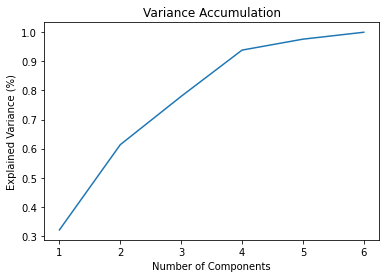

In [6]:
# pca with all components (6)
pca = PCA()

principal_components = pca.fit_transform(x_pca)
print("Variance explained by each Principal Component:", pca.explained_variance_ratio_)
cumulative_sum_variance = np.cumsum(pca.explained_variance_ratio_)
print("Cumulative sum of Variance explained by each Principal Component:", cumulative_sum_variance)
print("Variance explained by the 4 Principal Components alone:", sum(pca.explained_variance_ratio_[0:4]))

plt.plot(range(1, len(cumulative_sum_variance)+1), cumulative_sum_variance)
plt.xlabel("Number of Components")
_ = plt.ylabel("Explained Variance (%)")
_ = plt.title("Variance Accumulation")

## PCA with 2 Components

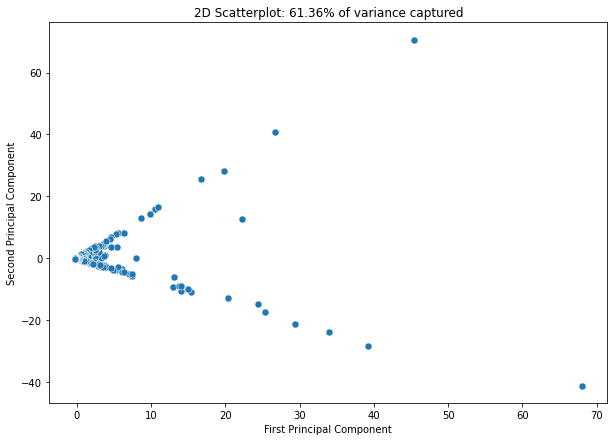

In [7]:
pca_2 = PCA(n_components=2)
pca_2.fit_transform(x_pca)

x_pca_2 = pca_2.transform(x_pca) # variable for scatterplot visualization

plt.figure(figsize=(10,7))
sns.scatterplot(x=x_pca_2[:,0], y=x_pca_2[:,1], s=50)
_ = plt.title(f"2D Scatterplot: {round(cumulative_sum_variance[1]*10000)/100}% of variance captured")
_ = plt.xlabel("First Principal Component")
_ = plt.ylabel("Second Principal Component")


## PCA with 3 Components

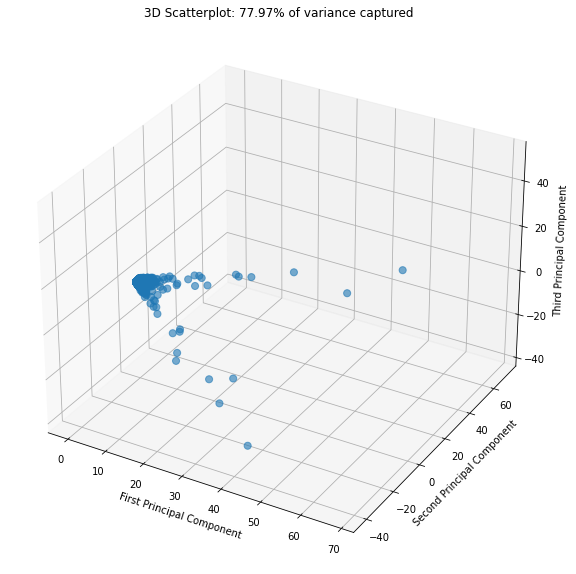

In [8]:
pca_3 = PCA(n_components=3)
pca_3.fit_transform(x_pca)

x_pca_3 = pca_3.transform(x_pca) # variable for scatterplot visualization

fig = plt.figure(figsize=(15,10))
ax = plt.axes(projection="3d")

sctt = ax.scatter3D(x_pca_3[:,0], x_pca_3[:,1], x_pca_3[:,2], s=50, alpha=0.6)
_ = plt.title(f"3D Scatterplot: {round(cumulative_sum_variance[2]*10000)/100}% of variance captured")
_ = ax.set_xlabel("First Principal Component")
_ = ax.set_ylabel("Second Principal Component")
_ = ax.set_zlabel("Third Principal Component")

## PCA with 4 Components

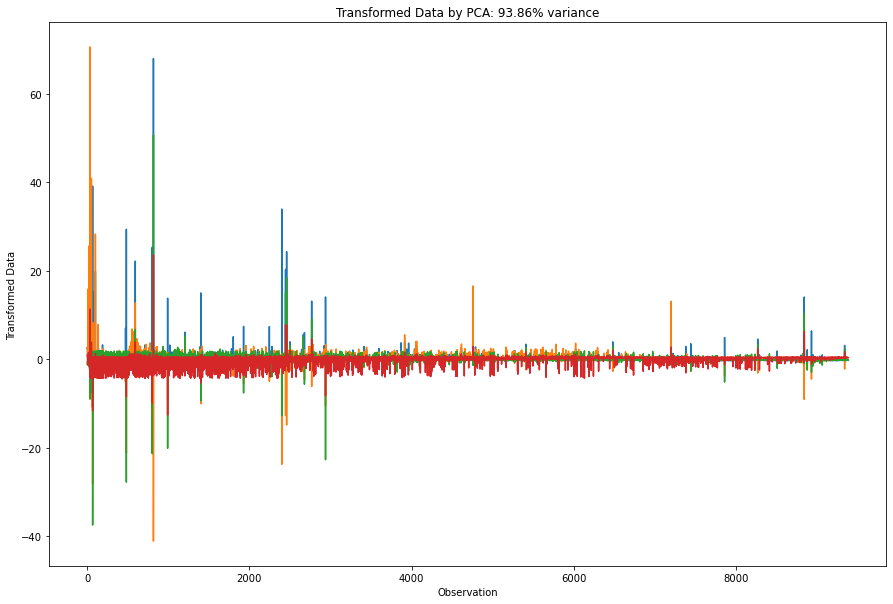

In [9]:
# pca with 4 Principal Components
pca_4 = PCA(n_components=4)
principal_components = pca_4.fit_transform(x_pca)
pca4_df = pd.DataFrame(principal_components)

x_pca_4 = pca_4.transform(x_pca) # variable for scatterplot visualization

plt.figure(figsize=(15,10))
plt.plot(x_pca_4)
_ = plt.title(f"Transformed Data by PCA: {round(cumulative_sum_variance[3]*10000)/100}% variance")
_ = plt.xlabel("Observation")
_ = plt.ylabel("Transformed Data")

# Clustering

## Clustering Tendency

- Hopkins Statistics: A statistical test which allow to guess if the data follow an uniform distribution. If the test is positve (an hopkins score which tends to 0) it means that the data is not uniformly distributed. Hence clustering can be useful to classify the observations

- VAT(visual assessment of tendency): An algorithm which create a visualisation of a specific dataset, this visualisation can be useful to obtain an insight on the number of cluster and cluster hierarchy. The algorithm create a minimum spanning tree of observations, The pairwise distance between those observations are displayed. The more the color is black, the more the distance between two observations is small. A way to interpert the image is to count the number of black square in the diagonal which should represent the number of cluster. 

In [10]:
# 0.0019: optimal clustering tendency
print("Hopkins Statistic:", pyclustertend.hopkins(x_pca_4, len(x_pca_4)))

Hopkins Statistic: 0.0019169745012073485


In [11]:
# pyclustertend.vat(x_pca_4)

## Clustering Quality

- Choice of *K*
    - Elbow Point
    - distance from random *(?)*
- Silhouette (inter/intra measures)

## Elbow Method

The Elbow Point is found at *k=10*, after which the plot reaches a plateau

In [12]:
sum_squared_dist = []
K = range(1,50)
for k in K:
    km = KMeans(n_clusters=k, random_state=0)
    km = km.fit(x_pca_4)
    sum_squared_dist.append(km.inertia_)

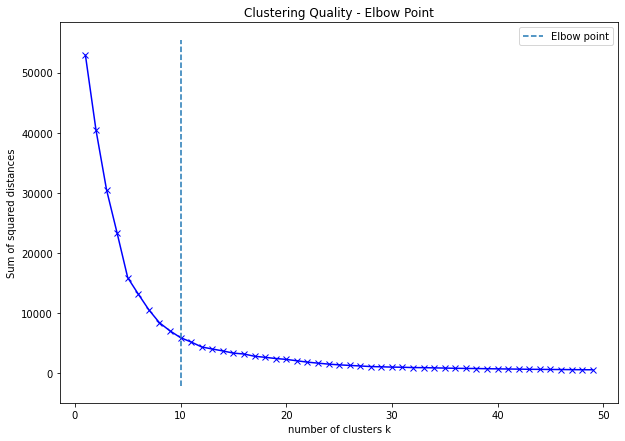

In [13]:
kn = KneeLocator(K, sum_squared_dist, curve='convex', direction='decreasing')

plt.figure(figsize=(10,7))
_ = plt.plot(K,sum_squared_dist, 'bx-')
_ = plt.title("Clustering Quality - Elbow Point")
_ = plt.xlabel('number of clusters k')
_ = plt.ylabel('Sum of squared distances')
_ = plt.vlines(kn.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed', label="Elbow point")
_ = plt.legend()

## Silhouette Analysis

The optimal number of clusters is found at *K=3*, with a Silhouette Score *>0.97*

In [14]:
silhouette_list = []
K = range(2,15)
for k in K:
    km = KMeans(n_clusters=k, random_state=0)
    km_labels = km.fit_predict(x_pca_4)
    silhouette_avg = silhouette_score(x_pca_4, km_labels)
    silhouette_list.append(silhouette_avg)

print(silhouette_list)

[0.9705058287352114, 0.9709825233859806, 0.7779897661709578, 0.781559485144289, 0.7794435585294283, 0.7782983994003454, 0.7794525165721377, 0.780121437844016, 0.7340066219114117, 0.7328809476403231, 0.7405610645721324, 0.6493104031873599, 0.6612099053321066]


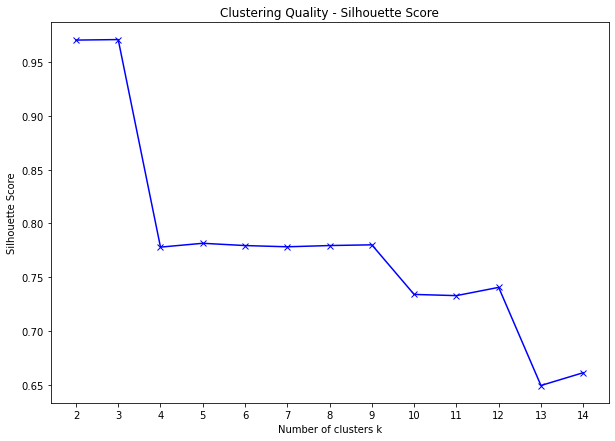

In [15]:
plt.figure(figsize=(10,7))
_ = plt.plot(K,silhouette_list, 'bx-')
_ = plt.title("Clustering Quality - Silhouette Score")
_ = plt.xlabel('Number of clusters k')
_ = plt.ylabel('Silhouette Score')
_ = plt.xticks(K)

In [36]:
fig, ax = plt.subplots(2, 2, figsize=(30,15))

k = 2
for i in [2, 3, 5, 10]:
    # Create KMeans instance for different number of clusters
    km = KMeans(n_clusters=i, init='k-means++', random_state=0)
    q, mod = divmod(k, 2)

    # Create SilhouetteVisualizer instance with KMeans instance and Fit the visualizer
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(x_pca_4)

    ax[q-1][mod].set_title(f"Silhouette Score for k={i}")
    ax[q-1][mod].set_xlabel("Silhouette Score")
    ax[q-1][mod].set_ylabel("Istances")

    k+=1

# Conclusions